
# Project Setup and Execution Instructions

## Overview
This notebook requires access to a specific folder in Google Drive. Follow the steps below to set up the project:

## Project Setup
1. Add a shortcut of this folder: [Shared Folder Link](https://drive.google.com/drive/folders/1ySpjMA1MVeFCnnFrjvxei4QucpDnk27e?usp=sharing) to your Google Drive directory: `/content/drive/MyDrive/Colab Notebooks/`

Adding shortcut steps:
1.1. Open the shared folder link.
1.2. Right click on the DL_course folder -> Organize -> Add shorcut.
1.3. A popup with "Add shortcut to DL_course" title will appear. Choose Colab Notebooks folder.

2. Verify the folder addition by running the `checkDriveDir` function. If successful, you should see a list of folders, including `chest_xray` and `winning_architecture`, confirming that the DL_course shortcut was added to your drive.

3. Run Notebook Cells: Execute the notebook cells one by one to perform the training.


## Imports

In [ ]:
import copy
import os
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F
from google.colab import drive
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import random


## Hyperparameters


In [ ]:

EPOCHS = 10
data_dir = "/content/drive/MyDrive/Colab Notebooks/DL_course/chest_xray"

TEST = 'test'
TRAIN = 'train'
VAL ='val'
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/DL_course"

checkpoint_with_focal_dir = checkpoint_dir + "/with_focal"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualization = True
from google.colab import drive
drive.mount('/content/drive')
device


device(type='cpu')

In [ ]:
def checkDriveDir():
  folders = [folder for folder in os.listdir(checkpoint_dir) if os.path.isdir(os.path.join(checkpoint_dir, folder))]

  # Print the list of folders
  if folders:
      print("List of Folders:")
      for folder in folders:
          print(f" - {folder}")
  else:
      print("No folders found in the /content/drive/MyDrive/Colab Notebooks/DL_course.")
checkDriveDir()

List of Folders:
 - chest_xray
 - with_focal
 - winning architecture
 - Output_1b
 - with_focal_backup
 - logs


**Task 1a - Classification healthy/sick Xray Imaging  🍒**


---



# Task 1.a - Classification of healthy/sick

## Accuracy Graph

In [ ]:
def accuracy_graph(train_losses, val_losses, train_accs, val_accs):
        # Plot training and validation loss
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training loss')
        plt.plot(val_losses, label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Training acc')
        plt.plot(val_accs, label='Validation acc')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.savefig(os.path.join(checkpoint_dir, 'training_validation_loss_acc.png'))
        plt.close()

## Model, Optimizer, Data Preprocessing




In [ ]:
# Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        pt = torch.exp(-BCE_loss)
        F_loss = at * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

In [ ]:
# Data Transformation & Augmentations
def data_transforms(phase):
    # If the phase is TRAIN
    if phase == TRAIN:
        # Compose transformations: Resize, CenterCrop, Convert to Tensor, Normalize
        transform = transforms.Compose([
            transforms.Resize(256),  # Resize the image to 256x256 pixels
            transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels
            transforms.ToTensor(),  # Convert the image to a PyTorch Tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # Normalize the Tensor
        ])

    # If the phase is VAL
    if phase == VAL:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # If the phase is TEST
    if phase == TEST:
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform

In [ ]:
# Prepere dataset and dataloader

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x))
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size=32, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size=1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=True)
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}

classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

## Training

In [ ]:
# Prepere training loop
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    # Initialize lists to track loss and accuracy
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                print("computing")
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == TRAIN:
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == TRAIN:
                scheduler.step()  # Update the learning rate after optimizer updates

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == TRAIN:
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.detach().cpu().numpy().min())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.detach().cpu().numpy().min())

            if phase == VAL and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            checkpoint_path = os.path.join(checkpoint_with_focal_dir, f"epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), checkpoint_path)

            if visualization:
                accuracy_graph(train_losses, val_losses, train_accs, val_accs)

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Prepere dataset and dataloader

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x))
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size=32, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size=1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=True)
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}

classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

## Train RestNet

In [ ]:
# Initializing Model and Train
model_pre = models.resnet18(pretrained=True)

for param in model_pre.parameters():
    param.requires_grad = True

model_pre.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)

model_pre = model_pre.to(device)
criterion = FocalLoss(alpha=0.25, gamma=2) #nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10
----------
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computin

## Train AlexNet

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms

# Load AlexNet pre-trained on ImageNet
model_pre = models.alexnet(pretrained=True)

# Freeze the pre-trained parameters
for param in model_pre.parameters():
    param.requires_grad = False

# Replace the classifier (fully connected layers) with a custom one
model_pre.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 2)  # Output layer for 2 classes (adjust based on your task)
).to(device)
num_epochs = 10

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pre.parameters(), lr=0.0001, eps = 0.0001/num_epochs)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Optionally, unfreeze the classifier parameters for fine-tuning
for param in model_pre.classifier.parameters():
    param.requires_grad = True

# Move the model to the appropriate device (e.g., GPU)
model_pre = model_pre.to(device)

# Define a function to train the model (implementation not provided)
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)


Epoch 1/10
----------
train Loss: 0.1309 Acc: 0.9513
val Loss: 0.0676 Acc: 1.0000
Epoch 2/10
----------
train Loss: 0.0861 Acc: 0.9701
val Loss: 0.2003 Acc: 0.9375
Epoch 3/10
----------
train Loss: 0.0589 Acc: 0.9766
val Loss: 0.3566 Acc: 0.8125
Epoch 4/10
----------
train Loss: 0.0489 Acc: 0.9810
val Loss: 0.1375 Acc: 0.9375
Epoch 5/10
----------
train Loss: 0.0309 Acc: 0.9881
val Loss: 0.3392 Acc: 0.8125
Epoch 6/10
----------
train Loss: 0.0378 Acc: 0.9862
val Loss: 0.3410 Acc: 0.8125
Epoch 7/10
----------
train Loss: 0.0233 Acc: 0.9916
val Loss: 1.7486 Acc: 0.5625
Epoch 8/10
----------
train Loss: 0.0308 Acc: 0.9887
val Loss: 0.2868 Acc: 0.8750
Epoch 9/10
----------
train Loss: 0.0289 Acc: 0.9881
val Loss: 0.2115 Acc: 0.9375
Epoch 10/10
----------
train Loss: 0.0301 Acc: 0.9883
val Loss: 0.1035 Acc: 0.9375
Best val Acc: 1.000000


## Train VGG16

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim import lr_scheduler

# Load VGG pre-trained on ImageNet
model_pre = models.vgg16(pretrained=True)

# Freeze the pre-trained parameters
for param in model_pre.parameters():
    param.requires_grad = False

# Replace the classifier (fully connected layers) with a custom one
num_features = model_pre.classifier[6].in_features
model_pre.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 2)  # Output layer for 2 classes (adjust based on your task)
)

num_epochs = 10

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pre.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Optionally, unfreeze the classifier parameters for fine-tuning
for param in model_pre.classifier.parameters():
    param.requires_grad = True

# Move the model to the appropriate device (e.g., GPU)

# Define a function to train the model (implementation not provided)
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.1548 Acc: 0.9358
val Loss: 0.3798 Acc: 0.7500
Epoch 2/10
----------
train Loss: 0.0691 Acc: 0.9751
val Loss: 0.1809 Acc: 0.9375
Epoch 3/10
----------
train Loss: 0.0439 Acc: 0.9864
val Loss: 0.1499 Acc: 0.9375
Epoch 4/10
----------
train Loss: 0.0336 Acc: 0.9879
val Loss: 0.2549 Acc: 0.9375
Epoch 5/10
----------
train Loss: 0.0251 Acc: 0.9918
val Loss: 0.2171 Acc: 0.9375
Epoch 6/10
----------
train Loss: 0.0204 Acc: 0.9918
val Loss: 0.2302 Acc: 0.9375
Epoch 7/10
----------
train Loss: 0.0250 Acc: 0.9914
val Loss: 0.4227 Acc: 0.8750
Epoch 8/10
----------
train Loss: 0.0154 Acc: 0.9958
val Loss: 0.5636 Acc: 0.8750
Epoch 9/10
----------
train Loss: 0.0161 Acc: 0.9927
val Loss: 0.5792 Acc: 0.8750
Epoch 10/10
----------
train Loss: 0.0098 Acc: 0.9969
val Loss: 0.4648 Acc: 0.8750
Best val Acc: 0.937500


**Task 1b - Classification healthy, bacterial and viral Xray Imaging  🌵**


# Task 1.b - Classification of healthy/bacterial pneumonia/viral pneumonia

## Revision For 3 classes - Modifiy Dataloader and Model Architecture

In [ ]:
# Model architecture (pretrain from 1a)
class ResNet3Classes(nn.Module):
    def __init__(self, pretrained_model):
        super(ResNet3Classes, self).__init__()
        self.pretrained = pretrained_model
        # Remove the last layer (classifier) to get the embeddings
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3)).to(device)


    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,512)
        x = self.fc(x)  # Flatten the features
        return x

In [ ]:
# Define New Dataloader for 3 classes, add one more label: "Normal" - label 0, "Virus" - label 1, for "bacteria": label 2
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Loop through each folder and file, assigning labels based on the criteria
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(subdir, file))
                    if 'NORMAL' in subdir:
                        self.labels.append(0)  # Normal
                    elif 'virus' in file.lower():
                        self.labels.append(1)  # Virus
                    elif 'bacteria' in file.lower():
                        self.labels.append(2)  # Bacteria

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Add this line if you need to convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [ ]:
image_datasets = {
    TRAIN: CustomDataset(os.path.join(data_dir, TRAIN), transform=data_transform),
    VAL: CustomDataset(os.path.join(data_dir, VAL), transform=data_transform),
    TEST: CustomDataset(os.path.join(data_dir, TEST), transform=data_transform)
}

dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size=64, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size=1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=True)
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}

## ResNet Training 3 classes

In [ ]:
# Change Model Architecture for 3 neurons output
model_pre = models.resnet18(pretrained=True)

for param in model_pre.parameters():
    param.requires_grad = True

model_pre.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 3)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Choose if load pretrained or start new training
INFERENCE = False

if INFERENCE:
    model_pre = models.resnet18(pretrained=True)
    model_pre.fc = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2)).to(device)
    model_pre = ResNet3Classes(model_pre)
    checkpoint_path = os.path.join(pre_train_dir, 'epoch_10_winning_1b.pth')
    checkpoint = torch.load(checkpoint_path)
    model_pre.load_state_dict(checkpoint)
    for param in model_pre.parameters():
        param.requires_grad = False
    model_pre.eval()
else:
    model_pre = models.resnet18(pretrained=True)
    model_pre.fc = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 2)).to(device)
    checkpoint = torch.load(os.path.join(pre_train_dir, 'epoch_7_winning_1a.pth'))
    model_pre.load_state_dict(checkpoint)
    for param in model_pre.parameters():
        param.requires_grad = False
    model_pre = ResNet3Classes(model_pre)

model_pre = model_pre.to(device)


In [ ]:
# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_pre.parameters(), lr=0.0001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)


Epoch 1/10
----------
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
train Loss: 1.0331 Acc: 0.5226
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computing
computi

## AlexNet Training and Testing 3 classes

In [ ]:
import torchvision.models as models
from torch.optim import lr_scheduler
# Change Model Architecture for 3 neurons output
model_pre = models.alexnet(pretrained=True)

# Freeze the pre-trained parameters
for param in model_pre.parameters():
    param.requires_grad = False


# Replace the classifier (fully connected layers) with a custom one
model_pre.classifier = nn.Sequential(
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 3)  # Output layer for 3 classes (adjust based on your task)
).to(device)
num_epochs = 10

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pre.parameters(), lr=0.0001, eps = 0.0001/num_epochs)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Optionally, unfreeze the classifier parameters for fine-tuning
for param in model_pre.classifier.parameters():
    param.requires_grad = True

# Move the model to the appropriate device (e.g., GPU)
model_pre = model_pre.to(device)

# Define a function to train the model (implementation not provided)
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 1/10
----------
train Loss: 0.5465 Acc: 0.7540
val Loss: 1.8295 Acc: 0.1875
Epoch 2/10
----------
train Loss: 0.4571 Acc: 0.7935
val Loss: 1.0463 Acc: 0.4375
Epoch 3/10
----------
train Loss: 0.4051 Acc: 0.8234
val Loss: 1.0481 Acc: 0.3750
Epoch 4/10
----------
train Loss: 0.3679 Acc: 0.8391
val Loss: 0.6548 Acc: 0.6875
Epoch 5/10
----------
train Loss: 0.3332 Acc: 0.8537
val Loss: 1.1631 Acc: 0.5000
Epoch 6/10
----------
train Loss: 0.3057 Acc: 0.8675
val Loss: 0.8290 Acc: 0.6250
Epoch 7/10
----------
train Loss: 0.2829 Acc: 0.8817
val Loss: 2.0722 Acc: 0.3125
Epoch 8/10
----------
train Loss: 0.2479 Acc: 0.8928
val Loss: 0.7510 Acc: 0.6875
Epoch 9/10
----------
train Loss: 0.2287 Acc: 0.9099
val Loss: 1.5115 Acc: 0.3125
Epoch 10/10
----------
train Loss: 0.2119 Acc: 0.9099
val Loss: 1.7222 Acc: 0.2500
Best val Acc: 0.687500


## VGG16 Training and Testing 3 classes

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
# Change Model Architecture for 3 neurons output
model_pre = models.vgg16(pretrained=True)

# Freeze the pre-trained parameters
for param in model_pre.parameters():
    param.requires_grad = False

# Replace the classifier (fully connected layers) with a custom one
num_features = model_pre.classifier[6].in_features
model_pre.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 3)  # Output layer for 2 classes (adjust based on your task)
)
num_epochs = 10

# Define loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pre.parameters(), lr=0.0001, eps = 0.0001/num_epochs)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Optionally, unfreeze the classifier parameters for fine-tuning
for param in model_pre.classifier.parameters():
    param.requires_grad = True

# Move the model to the appropriate device (e.g., GPU)
model_pre = model_pre.to(device)

# Define a function to train the model (implementation not provided)
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epoch 1/10
----------
train Loss: 0.6061 Acc: 0.7274
val Loss: 0.5891 Acc: 0.7500
Epoch 2/10
----------
train Loss: 0.4305 Acc: 0.8154
val Loss: 0.8717 Acc: 0.6875
Epoch 3/10
----------
train Loss: 0.3607 Acc: 0.8499
val Loss: 0.7576 Acc: 0.6875
Epoch 4/10
----------
train Loss: 0.2812 Acc: 0.8809
val Loss: 0.7511 Acc: 0.6875
Epoch 5/10
----------
train Loss: 0.2190 Acc: 0.9078
val Loss: 1.1697 Acc: 0.5000
Epoch 6/10
----------
train Loss: 0.1653 Acc: 0.9339
val Loss: 1.2995 Acc: 0.5625
Epoch 7/10
----------
train Loss: 0.1145 Acc: 0.9578
val Loss: 1.4564 Acc: 0.6250
Epoch 8/10
----------
train Loss: 0.0856 Acc: 0.9674
val Loss: 1.3199 Acc: 0.6250
Epoch 9/10
----------
train Loss: 0.0930 Acc: 0.9655
val Loss: 1.4374 Acc: 0.6250
Epoch 10/10
----------
train Loss: 0.0596 Acc: 0.9789
val Loss: 1.2715 Acc: 0.7500
Best val Acc: 0.750000


# Task 2 - Tsne Visualization for 1.a

In [ ]:
# Imports
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import torch

## Load Model


In [ ]:
checkpoint_path = checkpoint_dir + "/winning architecture/epoch_7_winning_1a.pth"
embedding_model = models.resnet18(pretrained=True)
embedding_model.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)
embedding_model = ResNet3Classes(embedding_model)
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device) )
embedding_model = embedding_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model and Data Initializaing

In [ ]:
# Dataloader and Transforms
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

In [ ]:
# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in [TRAIN, VAL, TEST]}
dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size=32, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size=1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=True)
}
dataloaders[TEST] = torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=False)

class_names = image_datasets[TRAIN].classes


In [ ]:
# Extract feature layers
class ResNet18Embedding(nn.Module):
    def __init__(self, pretrained_model):
        super(ResNet18Embedding, self).__init__()
        self.pretrained = pretrained_model
        # Remove the last layer (classifier) to get the embeddings
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features
        return x

Tsne and Embedding Visualizations

In [ ]:
# Aggregate embedding
def generate_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            embed = model(inputs)
            embeddings.append(embed.cpu().numpy())
            labels.append(label.numpy())
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

In [ ]:
checkpoint_path = checkpoint_dir + "/winning architecture/epoch_7_winning_1a.pth"

embedding_model = models.resnet18(pretrained=True)
embedding_model.fc = nn.Sequential(
    nn.Linear(512, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
embedding_model.load_state_dict(checkpoint)

embedding_model = ResNet18Embedding(embedding_model)
embedding_model = embedding_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from PIL import Image

train_embeddings, train_labels = generate_embeddings(dataloaders[TRAIN], embedding_model)


In [ ]:
train_embeddings_path = checkpoint_dir + "/winning architecture/train_embeddings.csv"
# Save train_embeddings to a file
np.savetxt(train_embeddings_path, train_embeddings, delimiter=',')

train_labels_path = checkpoint_dir + "/winning architecture/train_labels.csv"
# Save train_embeddings to a file
np.savetxt(train_labels_path, train_labels, delimiter=',')

In [ ]:
# Apply TSNE on Training set
tsne = TSNE(n_components=2, random_state=0)
train_tsne_embeddings = tsne.fit_transform(train_embeddings)

In [ ]:
len(train_tsne_embeddings)

5216

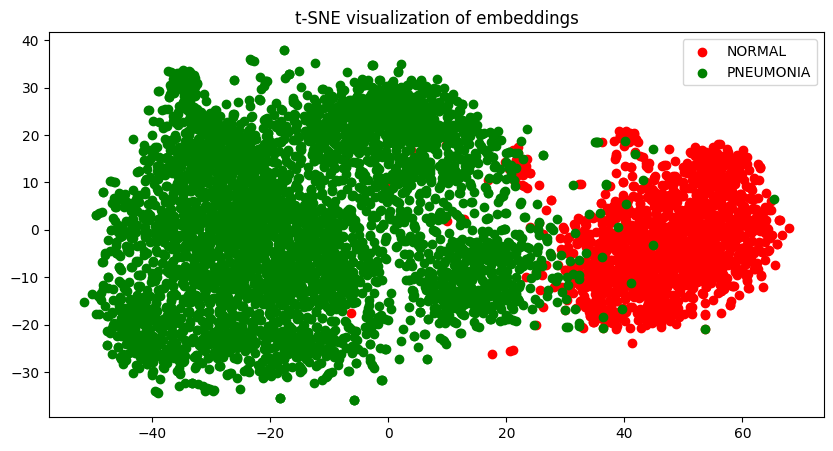

In [ ]:
# Visualization of train samples latent space
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i, label in enumerate(np.unique(train_labels)):
    indices = np.where(train_labels == label)
    plt.scatter(train_tsne_embeddings[indices, 0], train_tsne_embeddings[indices, 1], c=colors[i], label=class_names[label])
plt.legend()
plt.title("t-SNE visualization of embeddings")
plt.show()

In [ ]:
# Aggergate test embedding
# This part related to test but since it takes time to run it, we will run it in train notebook and will load the output in test notebook
test_embeddings, test_labels = generate_embeddings(dataloaders[TEST], embedding_model)

In [ ]:
test_embeddings_path = checkpoint_dir + "/winning architecture/test_embeddings.csv"
test_labels_path = checkpoint_dir + "/winning architecture/test_labels.csv"

# Save the embeddings and labels to a file
np.savetxt(test_embeddings_path, test_embeddings, delimiter=',')
np.savetxt(test_labels_path, test_labels, delimiter=',')

# Task 2 - Tsne Visualization for 1.b

In [ ]:
class VGG3Classes(nn.Module):
    def __init__(self, pretrained_model):
        super(VGG3Classes, self).__init__()
        self.pretrained = pretrained_model
        # Remove the last layer (classifier) to get the embeddings
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])



    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x,1)
        return x

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Loop through each folder and file, assigning labels based on the criteria
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append(os.path.join(subdir, file))
                    if 'NORMAL' in subdir:
                        self.labels.append(0)  # Normal
                    elif 'virus' in file.lower():
                        self.labels.append(1)  # Virus
                    elif 'bacteria' in file.lower():
                        self.labels.append(2)  # Bacteria
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3),  # Add this line if you need to convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


image_datasets = {
    TRAIN: CustomDataset(os.path.join(data_dir, TRAIN), transform=data_transform),
    VAL: CustomDataset(os.path.join(data_dir, VAL), transform=data_transform),
    TEST: CustomDataset(os.path.join(data_dir, TEST), transform=data_transform)
}

dataloaders = {
    TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size=32, shuffle=True),
    VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size=1, shuffle=True),
    TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size=1, shuffle=True)
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in [TRAIN, VAL]
}

In [ ]:
# Load Model
checkpoint_path_VGG = checkpoint_dir + "/winning architecture/VGG16_3classes.pth"
embedding_model = models.vgg16(pretrained=True)
num_features = embedding_model.classifier[6].in_features
embedding_model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 3)  # Output layer for 2 classes (adjust based on your task)
).to(device)
embedding_model = VGG3Classes(embedding_model)
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
embedding_model = embedding_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Aggregate embedding
def generate_embeddings(dataloader, model):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for inputs, label in dataloader:
            inputs = inputs.to(device)
            embed = model(inputs)
            embeddings.append(embed.cpu().numpy())
            labels.append(label.numpy())
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    return embeddings, labels

In [ ]:
from PIL import Image

train_embeddings, train_labels = generate_embeddings(dataloaders[TRAIN], embedding_model)


In [ ]:
train_embeddings_path = checkpoint_dir + "/winning architecture/train_embeddings_3.csv"
# Save train_embeddings to a file
np.savetxt(train_embeddings_path, train_embeddings, delimiter=',')

train_labels_path = checkpoint_dir + "/winning architecture/train_labels_3.csv"
# Save train_embeddings to a file
np.savetxt(train_labels_path, train_labels, delimiter=',')

In [ ]:
# Apply TSNE on Training set
tsne = TSNE(n_components=2, random_state=0)
train_tsne_embeddings = tsne.fit_transform(train_embeddings)

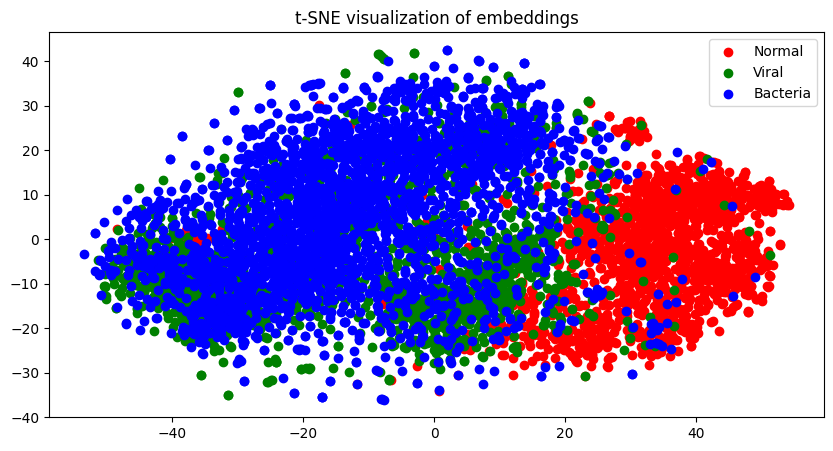

In [ ]:
class_names = ["Normal", "Viral", "Bacteria"]


# Visualization of train samples latent space
plt.figure(figsize=(10, 5))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
for i, label in enumerate(np.unique(train_labels)):
    indices = np.where(train_labels == label)
    plt.scatter(train_tsne_embeddings[indices, 0], train_tsne_embeddings[indices, 1], c=colors[i], label=class_names[label])
plt.legend()
plt.title("t-SNE visualization of embeddings")
plt.show()

In [ ]:
# Aggergate test embedding
# This part related to test but since it takes time to run it, we will run it in train notebook and will load the output in test notebook

test_embeddings, test_labels = generate_embeddings(dataloaders[TEST], embedding_model)

In [ ]:
test_embeddings_path = checkpoint_dir + "/winning architecture/test_embeddings_3.csv"
test_labels_path = checkpoint_dir + "/winning architecture/test_labels_3.csv"

# Save the embeddings and labels to a file
np.savetxt(test_embeddings_path, test_embeddings, delimiter=',')
np.savetxt(test_labels_path, test_labels, delimiter=',')

# Task 3 - Anomaly Detection

### Autoencoder Model

In [ ]:
import torch.nn as nn

class AE(nn.Module):
    def __init__(self, latent_size, multiplier=4, img_size=64):
        super(AE, self).__init__()
        out_channels = 1
        self.fm = img_size // 16
        self.mp = multiplier
        self.encoder = nn.Sequential(
            nn.Conv2d(1, int(16 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(16 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(16 * multiplier),
                      int(32 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(32 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(32 * multiplier),
                      int(64 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64 * multiplier)),
            nn.ReLU(True),
            nn.Conv2d(int(64 * multiplier),
                      int(64 * multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64 * multiplier)),
            nn.ReLU(True),
        )
        self.linear_enc = nn.Sequential(
            nn.Linear(int(64 * multiplier) * self.fm*self.fm, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Linear(2048, latent_size),
        )


        self.linear_dec = nn.Sequential(
            nn.Linear(latent_size, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(True),
            nn.Linear(2048, int(64 * multiplier) * self.fm*self.fm),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(int(64*multiplier), int(64 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(64*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(64*multiplier), int(32 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(32*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(32*multiplier), int(16 *
                                                       multiplier), 4, 2, 1, bias=False),
            nn.BatchNorm2d(int(16*multiplier)),
            nn.ReLU(True),
            nn.ConvTranspose2d(int(16*multiplier),
                               out_channels, 4, 2, 1, bias=False),
        )

    def forward(self, x):
        lat_rep = self.feature(x)
        out = self.decode(lat_rep)
        return out

    def feature(self, x):
        lat_rep = self.encoder(x)
        lat_rep = lat_rep.view(lat_rep.size(0), -1)
        lat_rep = self.linear_enc(lat_rep)
        return lat_rep

    def decode(self, x):
        out = self.linear_dec(x)
        out = out.view(out.size(0), int(64 * self.mp), self.fm, self.fm)
        out = self.decoder(out)
        return out


### Loading Data

In [ ]:
import cv2
import os
import glob as gb
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64
IMG_SIZE = 64
path='chest_xray/'
NORMAL = 'NORMAL'
BACTERIA = 'bacteria'
VIRAL = 'virus'
PNEUMONIA = 'PNEUMONIA'
code = {NORMAL:0 ,PNEUMONIA:1 }


X_train_normal = []
y_train_normal = []
for folder in  os.listdir(path) :
    files = gb.glob(pathname= str( path + 'train/NORMAL/*.jpeg'))
    for file in files:

        # Read the image
        image = cv2.imread(file)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Resize the grayscale image to 64x64 pixels
        resized_image = cv2.resize(gray_image, (64, 64))

        # Append the resized grayscale image to X_train

        X_train_normal.append(resized_image)
        y_train_normal.append(code[NORMAL])

np.save('X_train_gray_noraml',X_train_normal)
np.save('y_train_gray_normal',y_train_normal)
# Load preprocessed data
X_train = np.load('X_train_gray_noraml.npy')
y_train = np.load('y_train_gray_normal.npy')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# Define dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Trainign AE

  0%|          | 1/250 [00:03<14:57,  3.60s/it]

epochs:0, loss:19157.31396484375


  1%|          | 2/250 [00:07<16:44,  4.05s/it]

epochs:1, loss:18912.947265625


  1%|          | 3/250 [00:11<15:59,  3.88s/it]

epochs:2, loss:18649.65234375


  2%|▏         | 4/250 [00:14<13:59,  3.41s/it]

epochs:3, loss:18579.84716796875


  2%|▏         | 5/250 [00:17<13:55,  3.41s/it]

epochs:4, loss:18478.00146484375


  2%|▏         | 6/250 [00:21<14:58,  3.68s/it]

epochs:5, loss:18401.6650390625


  3%|▎         | 7/250 [00:26<15:39,  3.87s/it]

epochs:6, loss:18402.40478515625


  3%|▎         | 8/250 [00:29<14:38,  3.63s/it]

epochs:7, loss:18281.39990234375


  4%|▎         | 9/250 [00:33<14:50,  3.69s/it]

epochs:8, loss:18217.1552734375


  4%|▍         | 10/250 [00:37<15:23,  3.85s/it]

epochs:9, loss:18102.06640625


  4%|▍         | 11/250 [00:41<15:33,  3.91s/it]

epochs:10, loss:18051.77978515625


  5%|▍         | 12/250 [00:44<14:42,  3.71s/it]

epochs:11, loss:18017.6884765625


  5%|▌         | 13/250 [00:48<14:43,  3.73s/it]

epochs:12, loss:18015.32958984375


  6%|▌         | 14/250 [00:52<14:32,  3.70s/it]

epochs:13, loss:17864.373046875


  6%|▌         | 15/250 [00:55<14:32,  3.71s/it]

epochs:14, loss:17760.16650390625


  6%|▋         | 16/250 [00:58<13:32,  3.47s/it]

epochs:15, loss:17682.220703125


  7%|▋         | 17/250 [01:01<12:52,  3.32s/it]

epochs:16, loss:17633.69091796875


  7%|▋         | 18/250 [01:04<12:23,  3.20s/it]

epochs:17, loss:17635.67626953125


  8%|▊         | 19/250 [01:07<12:10,  3.16s/it]

epochs:18, loss:17510.48974609375


  8%|▊         | 20/250 [01:12<14:07,  3.69s/it]

epochs:19, loss:17477.6845703125


  8%|▊         | 21/250 [01:17<15:12,  3.98s/it]

epochs:20, loss:17353.23681640625


  9%|▉         | 22/250 [01:20<14:35,  3.84s/it]

epochs:21, loss:17355.7568359375


  9%|▉         | 23/250 [01:23<13:20,  3.52s/it]

epochs:22, loss:17161.9267578125


 10%|▉         | 24/250 [01:26<12:22,  3.29s/it]

epochs:23, loss:17133.115234375


 10%|█         | 25/250 [01:28<11:40,  3.11s/it]

epochs:24, loss:16978.85546875


 10%|█         | 26/250 [01:31<11:12,  3.00s/it]

epochs:25, loss:16858.646484375


 11%|█         | 27/250 [01:34<11:11,  3.01s/it]

epochs:26, loss:16883.38232421875


 11%|█         | 28/250 [01:37<10:55,  2.95s/it]

epochs:27, loss:16841.83203125


 12%|█▏        | 29/250 [01:40<10:36,  2.88s/it]

epochs:28, loss:16674.1533203125


 12%|█▏        | 30/250 [01:43<10:28,  2.85s/it]

epochs:29, loss:16626.20361328125


 12%|█▏        | 31/250 [01:45<10:18,  2.82s/it]

epochs:30, loss:16434.37109375


 13%|█▎        | 32/250 [01:48<10:30,  2.89s/it]

epochs:31, loss:16385.789306640625


 13%|█▎        | 33/250 [01:52<10:51,  3.00s/it]

epochs:32, loss:16313.111083984375


 14%|█▎        | 34/250 [01:56<11:51,  3.30s/it]

epochs:33, loss:16171.825439453125


 14%|█▍        | 35/250 [01:59<12:21,  3.45s/it]

epochs:34, loss:16085.586669921875


 14%|█▍        | 36/250 [02:03<12:41,  3.56s/it]

epochs:35, loss:16034.718505859375


 15%|█▍        | 37/250 [02:06<11:53,  3.35s/it]

epochs:36, loss:15913.523193359375


 15%|█▌        | 38/250 [02:09<11:20,  3.21s/it]

epochs:37, loss:15827.81640625


 16%|█▌        | 39/250 [02:12<11:00,  3.13s/it]

epochs:38, loss:15712.570068359375


 16%|█▌        | 40/250 [02:15<10:51,  3.10s/it]

epochs:39, loss:15673.287109375


 16%|█▋        | 41/250 [02:18<10:24,  2.99s/it]

epochs:40, loss:15471.573486328125


 17%|█▋        | 42/250 [02:20<10:09,  2.93s/it]

epochs:41, loss:15419.430908203125


 17%|█▋        | 43/250 [02:23<09:58,  2.89s/it]

epochs:42, loss:15377.199951171875


 18%|█▊        | 44/250 [02:26<09:42,  2.83s/it]

epochs:43, loss:15189.465576171875


 18%|█▊        | 45/250 [02:29<09:41,  2.83s/it]

epochs:44, loss:15053.167724609375


 18%|█▊        | 46/250 [02:32<09:33,  2.81s/it]

epochs:45, loss:15001.73876953125


 19%|█▉        | 47/250 [02:34<09:36,  2.84s/it]

epochs:46, loss:14946.146728515625


 19%|█▉        | 48/250 [02:37<09:25,  2.80s/it]

epochs:47, loss:14777.574951171875


 20%|█▉        | 49/250 [02:40<09:07,  2.72s/it]

epochs:48, loss:14675.7080078125


 20%|██        | 50/250 [02:43<09:09,  2.75s/it]

epochs:49, loss:14549.567138671875


 20%|██        | 51/250 [02:45<09:01,  2.72s/it]

epochs:50, loss:14489.198974609375


 21%|██        | 52/250 [02:50<10:49,  3.28s/it]

epochs:51, loss:14435.46728515625


 21%|██        | 53/250 [02:54<11:22,  3.46s/it]

epochs:52, loss:14302.371337890625


 22%|██▏       | 54/250 [02:58<12:06,  3.71s/it]

epochs:53, loss:14160.932861328125


 22%|██▏       | 55/250 [03:02<12:02,  3.70s/it]

epochs:54, loss:14062.062255859375


 22%|██▏       | 56/250 [03:05<11:47,  3.64s/it]

epochs:55, loss:13886.092041015625


 23%|██▎       | 57/250 [03:10<12:53,  4.01s/it]

epochs:56, loss:13826.09765625


 23%|██▎       | 58/250 [03:14<12:26,  3.89s/it]

epochs:57, loss:13664.501953125


 24%|██▎       | 59/250 [03:17<11:41,  3.67s/it]

epochs:58, loss:13664.235107421875


 24%|██▍       | 60/250 [03:19<10:39,  3.36s/it]

epochs:59, loss:13502.154296875


 24%|██▍       | 61/250 [03:22<10:15,  3.26s/it]

epochs:60, loss:13328.4833984375


 25%|██▍       | 62/250 [03:25<09:35,  3.06s/it]

epochs:61, loss:13244.932861328125


 25%|██▌       | 63/250 [03:28<09:14,  2.96s/it]

epochs:62, loss:13161.841796875


 26%|██▌       | 64/250 [03:30<08:56,  2.88s/it]

epochs:63, loss:13118.673583984375


 26%|██▌       | 65/250 [03:33<08:42,  2.82s/it]

epochs:64, loss:12900.932861328125


 26%|██▋       | 66/250 [03:36<08:31,  2.78s/it]

epochs:65, loss:12817.40673828125


 27%|██▋       | 67/250 [03:39<08:23,  2.75s/it]

epochs:66, loss:12680.238525390625


 27%|██▋       | 68/250 [03:42<08:37,  2.85s/it]

epochs:67, loss:12576.274658203125


 28%|██▊       | 69/250 [03:45<08:51,  2.94s/it]

epochs:68, loss:12501.8544921875


 28%|██▊       | 70/250 [03:48<08:52,  2.96s/it]

epochs:69, loss:12349.90234375


 28%|██▊       | 71/250 [03:51<08:53,  2.98s/it]

epochs:70, loss:12217.157958984375


 29%|██▉       | 72/250 [03:54<08:55,  3.01s/it]

epochs:71, loss:12212.359619140625


 29%|██▉       | 73/250 [03:57<08:45,  2.97s/it]

epochs:72, loss:11940.76806640625


 30%|██▉       | 74/250 [04:00<08:45,  2.99s/it]

epochs:73, loss:11883.557373046875


 30%|███       | 75/250 [04:03<08:56,  3.06s/it]

epochs:74, loss:11817.235107421875


 30%|███       | 76/250 [04:06<08:49,  3.04s/it]

epochs:75, loss:11693.1982421875


 31%|███       | 77/250 [04:09<08:32,  2.96s/it]

epochs:76, loss:11601.73046875


 31%|███       | 78/250 [04:12<08:39,  3.02s/it]

epochs:77, loss:11506.3388671875


 32%|███▏      | 79/250 [04:15<08:37,  3.02s/it]

epochs:78, loss:11309.837890625


 32%|███▏      | 80/250 [04:18<08:33,  3.02s/it]

epochs:79, loss:11260.086669921875


 32%|███▏      | 81/250 [04:21<08:32,  3.03s/it]

epochs:80, loss:11143.908203125


 33%|███▎      | 82/250 [04:24<08:27,  3.02s/it]

epochs:81, loss:11015.33642578125


 33%|███▎      | 83/250 [04:27<08:29,  3.05s/it]

epochs:82, loss:10932.46044921875


 34%|███▎      | 84/250 [04:30<08:13,  2.97s/it]

epochs:83, loss:10762.6748046875


 34%|███▍      | 85/250 [04:33<08:29,  3.09s/it]

epochs:84, loss:10686.389404296875


 34%|███▍      | 86/250 [04:37<09:14,  3.38s/it]

epochs:85, loss:10580.031982421875


 35%|███▍      | 87/250 [04:42<10:19,  3.80s/it]

epochs:86, loss:10373.248779296875


 35%|███▌      | 88/250 [04:46<10:20,  3.83s/it]

epochs:87, loss:10338.629638671875


 36%|███▌      | 89/250 [04:49<09:30,  3.54s/it]

epochs:88, loss:10216.224853515625


 36%|███▌      | 90/250 [04:52<08:46,  3.29s/it]

epochs:89, loss:10156.473388671875


 36%|███▋      | 91/250 [04:55<08:25,  3.18s/it]

epochs:90, loss:10012.54248046875


 37%|███▋      | 92/250 [04:57<08:12,  3.12s/it]

epochs:91, loss:9927.166015625


 37%|███▋      | 93/250 [05:00<07:52,  3.01s/it]

epochs:92, loss:9768.535400390625


 38%|███▊      | 94/250 [05:03<07:43,  2.97s/it]

epochs:93, loss:9672.15966796875


 38%|███▊      | 95/250 [05:06<07:33,  2.92s/it]

epochs:94, loss:9586.43212890625


 38%|███▊      | 96/250 [05:09<07:29,  2.92s/it]

epochs:95, loss:9452.456298828125


 39%|███▉      | 97/250 [05:12<07:32,  2.96s/it]

epochs:96, loss:9308.673828125


 39%|███▉      | 98/250 [05:15<07:26,  2.94s/it]

epochs:97, loss:9220.595703125


 40%|███▉      | 99/250 [05:18<07:21,  2.93s/it]

epochs:98, loss:9156.586181640625


 40%|████      | 100/250 [05:21<07:14,  2.90s/it]

epochs:99, loss:9023.745361328125


 40%|████      | 101/250 [05:24<07:25,  2.99s/it]

epochs:100, loss:8962.66943359375


 41%|████      | 102/250 [05:27<07:15,  2.94s/it]

epochs:101, loss:8816.218017578125


 41%|████      | 103/250 [05:29<07:08,  2.91s/it]

epochs:102, loss:8714.71533203125


 42%|████▏     | 104/250 [05:32<06:57,  2.86s/it]

epochs:103, loss:8544.08740234375


 42%|████▏     | 105/250 [05:35<06:52,  2.84s/it]

epochs:104, loss:8468.780151367188


 42%|████▏     | 106/250 [05:38<06:58,  2.91s/it]

epochs:105, loss:8421.6240234375


 43%|████▎     | 107/250 [05:41<06:54,  2.90s/it]

epochs:106, loss:8308.879516601562


 43%|████▎     | 108/250 [05:44<06:46,  2.86s/it]

epochs:107, loss:8146.29052734375


 44%|████▎     | 109/250 [05:46<06:38,  2.83s/it]

epochs:108, loss:8082.342041015625


 44%|████▍     | 110/250 [05:49<06:41,  2.86s/it]

epochs:109, loss:7983.6234130859375


 44%|████▍     | 111/250 [05:52<06:46,  2.92s/it]

epochs:110, loss:7888.228515625


 45%|████▍     | 112/250 [05:55<06:34,  2.86s/it]

epochs:111, loss:7775.856689453125


 45%|████▌     | 113/250 [05:58<06:16,  2.75s/it]

epochs:112, loss:7692.919677734375


 46%|████▌     | 114/250 [06:00<06:06,  2.70s/it]

epochs:113, loss:7575.663330078125


 46%|████▌     | 115/250 [06:04<06:32,  2.91s/it]

epochs:114, loss:7504.290771484375


 46%|████▋     | 116/250 [06:07<06:53,  3.09s/it]

epochs:115, loss:7353.7218017578125


 47%|████▋     | 117/250 [06:11<07:08,  3.22s/it]

epochs:116, loss:7264.8033447265625


 47%|████▋     | 118/250 [06:13<06:50,  3.11s/it]

epochs:117, loss:7224.0057373046875


 48%|████▊     | 119/250 [06:16<06:20,  2.90s/it]

epochs:118, loss:7095.9251708984375


 48%|████▊     | 120/250 [06:18<06:01,  2.78s/it]

epochs:119, loss:7005.9779052734375


 48%|████▊     | 121/250 [06:21<05:50,  2.71s/it]

epochs:120, loss:6926.898681640625


 49%|████▉     | 122/250 [06:24<05:44,  2.69s/it]

epochs:121, loss:6860.15869140625


 49%|████▉     | 123/250 [06:27<05:53,  2.78s/it]

epochs:122, loss:6752.0079345703125


 50%|████▉     | 124/250 [06:29<05:38,  2.69s/it]

epochs:123, loss:6595.6778564453125


 50%|█████     | 125/250 [06:32<05:28,  2.63s/it]

epochs:124, loss:6540.60205078125


 50%|█████     | 126/250 [06:34<05:28,  2.65s/it]

epochs:125, loss:6487.36083984375


 51%|█████     | 127/250 [06:37<05:15,  2.56s/it]

epochs:126, loss:6390.7012939453125


 51%|█████     | 128/250 [06:39<05:08,  2.53s/it]

epochs:127, loss:6333.40771484375


 52%|█████▏    | 129/250 [06:41<04:59,  2.48s/it]

epochs:128, loss:6193.5567626953125


 52%|█████▏    | 130/250 [06:44<04:54,  2.45s/it]

epochs:129, loss:6116.61669921875


 52%|█████▏    | 131/250 [06:46<04:49,  2.43s/it]

epochs:130, loss:6065.011474609375


 53%|█████▎    | 132/250 [06:49<04:47,  2.44s/it]

epochs:131, loss:5959.8524169921875


 53%|█████▎    | 133/250 [06:51<04:43,  2.42s/it]

epochs:132, loss:5864.2835693359375


 54%|█████▎    | 134/250 [06:53<04:39,  2.41s/it]

epochs:133, loss:5775.775146484375


 54%|█████▍    | 135/250 [06:56<04:37,  2.41s/it]

epochs:134, loss:5687.549072265625


 54%|█████▍    | 136/250 [06:59<04:45,  2.50s/it]

epochs:135, loss:5594.753173828125


 55%|█████▍    | 137/250 [07:01<04:47,  2.54s/it]

epochs:136, loss:5537.4306640625


 55%|█████▌    | 138/250 [07:04<04:49,  2.58s/it]

epochs:137, loss:5426.766845703125


 56%|█████▌    | 139/250 [07:06<04:44,  2.56s/it]

epochs:138, loss:5342.5657958984375


 56%|█████▌    | 140/250 [07:09<04:43,  2.57s/it]

epochs:139, loss:5298.4530029296875


 56%|█████▋    | 141/250 [07:12<04:44,  2.61s/it]

epochs:140, loss:5238.5987548828125


 57%|█████▋    | 142/250 [07:14<04:38,  2.58s/it]

epochs:141, loss:5066.3680419921875


 57%|█████▋    | 143/250 [07:17<04:36,  2.59s/it]

epochs:142, loss:5058.985107421875


 58%|█████▊    | 144/250 [07:19<04:32,  2.57s/it]

epochs:143, loss:4934.417236328125


 58%|█████▊    | 145/250 [07:22<04:38,  2.65s/it]

epochs:144, loss:4836.0289306640625


 58%|█████▊    | 146/250 [07:25<04:38,  2.68s/it]

epochs:145, loss:4809.08056640625


 59%|█████▉    | 147/250 [07:27<04:33,  2.66s/it]

epochs:146, loss:4682.551513671875


 59%|█████▉    | 148/250 [07:30<04:26,  2.62s/it]

epochs:147, loss:4660.731201171875


 60%|█████▉    | 149/250 [07:33<04:23,  2.61s/it]

epochs:148, loss:4595.04150390625


 60%|██████    | 150/250 [07:35<04:20,  2.60s/it]

epochs:149, loss:4462.1507568359375


 60%|██████    | 151/250 [07:38<04:17,  2.60s/it]

epochs:150, loss:4368.503967285156


 61%|██████    | 152/250 [07:40<04:17,  2.63s/it]

epochs:151, loss:4332.6231689453125


 61%|██████    | 153/250 [07:43<04:15,  2.63s/it]

epochs:152, loss:4248.0587158203125


 62%|██████▏   | 154/250 [07:46<04:16,  2.67s/it]

epochs:153, loss:4229.8157958984375


 62%|██████▏   | 155/250 [07:48<04:11,  2.65s/it]

epochs:154, loss:4129.2198486328125


 62%|██████▏   | 156/250 [07:51<04:14,  2.70s/it]

epochs:155, loss:4057.2349243164062


 63%|██████▎   | 157/250 [07:54<04:18,  2.78s/it]

epochs:156, loss:4006.2261352539062


 63%|██████▎   | 158/250 [07:57<04:13,  2.76s/it]

epochs:157, loss:3916.8595581054688


 64%|██████▎   | 159/250 [08:00<04:11,  2.77s/it]

epochs:158, loss:3882.6324462890625


 64%|██████▍   | 160/250 [08:02<04:02,  2.70s/it]

epochs:159, loss:3809.6434326171875


 64%|██████▍   | 161/250 [08:05<04:04,  2.75s/it]

epochs:160, loss:3701.5403442382812


 65%|██████▍   | 162/250 [08:08<04:00,  2.73s/it]

epochs:161, loss:3647.0254516601562


 65%|██████▌   | 163/250 [08:10<03:53,  2.68s/it]

epochs:162, loss:3607.3335571289062


 66%|██████▌   | 164/250 [08:13<03:51,  2.69s/it]

epochs:163, loss:3535.0451049804688


 66%|██████▌   | 165/250 [08:16<03:54,  2.76s/it]

epochs:164, loss:3475.6104736328125


 66%|██████▋   | 166/250 [08:19<03:51,  2.75s/it]

epochs:165, loss:3385.1905517578125


 67%|██████▋   | 167/250 [08:21<03:46,  2.72s/it]

epochs:166, loss:3354.5894165039062


 67%|██████▋   | 168/250 [08:24<03:38,  2.66s/it]

epochs:167, loss:3305.9954223632812


 68%|██████▊   | 169/250 [08:27<03:33,  2.64s/it]

epochs:168, loss:3318.981689453125


 68%|██████▊   | 170/250 [08:29<03:30,  2.64s/it]

epochs:169, loss:3217.2615966796875


 68%|██████▊   | 171/250 [08:32<03:28,  2.63s/it]

epochs:170, loss:3076.3406372070312


 69%|██████▉   | 172/250 [08:34<03:26,  2.64s/it]

epochs:171, loss:3001.7604370117188


 69%|██████▉   | 173/250 [08:37<03:26,  2.68s/it]

epochs:172, loss:2932.5728149414062


 70%|██████▉   | 174/250 [08:40<03:23,  2.68s/it]

epochs:173, loss:2894.3506469726562


 70%|███████   | 175/250 [08:42<03:18,  2.65s/it]

epochs:174, loss:2821.0410766601562


 70%|███████   | 176/250 [08:45<03:13,  2.62s/it]

epochs:175, loss:2777.83642578125


 71%|███████   | 177/250 [08:48<03:16,  2.69s/it]

epochs:176, loss:2709.3363647460938


 71%|███████   | 178/250 [08:51<03:14,  2.70s/it]

epochs:177, loss:2666.1240234375


 72%|███████▏  | 179/250 [08:53<03:08,  2.66s/it]

epochs:178, loss:2626.0810546875


 72%|███████▏  | 180/250 [08:56<03:07,  2.67s/it]

epochs:179, loss:2607.8108520507812


 72%|███████▏  | 181/250 [08:59<03:04,  2.68s/it]

epochs:180, loss:2513.1885986328125


 73%|███████▎  | 182/250 [09:01<02:56,  2.59s/it]

epochs:181, loss:2451.0543212890625


 73%|███████▎  | 183/250 [09:04<02:55,  2.62s/it]

epochs:182, loss:2416.3944091796875


 74%|███████▎  | 184/250 [09:06<02:51,  2.60s/it]

epochs:183, loss:2404.46240234375


 74%|███████▍  | 185/250 [09:09<02:48,  2.60s/it]

epochs:184, loss:2341.2283325195312


 74%|███████▍  | 186/250 [09:11<02:48,  2.63s/it]

epochs:185, loss:2293.9859619140625


 75%|███████▍  | 187/250 [09:14<02:48,  2.67s/it]

epochs:186, loss:2247.0956420898438


 75%|███████▌  | 188/250 [09:17<02:42,  2.63s/it]

epochs:187, loss:2210.979736328125


 76%|███████▌  | 189/250 [09:20<02:42,  2.66s/it]

epochs:188, loss:2173.5411376953125


 76%|███████▌  | 190/250 [09:22<02:39,  2.66s/it]

epochs:189, loss:2130.169708251953


 76%|███████▋  | 191/250 [09:25<02:39,  2.70s/it]

epochs:190, loss:2097.9236450195312


 77%|███████▋  | 192/250 [09:28<02:35,  2.67s/it]

epochs:191, loss:2074.3580932617188


 77%|███████▋  | 193/250 [09:30<02:33,  2.70s/it]

epochs:192, loss:2004.1190490722656


 78%|███████▊  | 194/250 [09:33<02:30,  2.70s/it]

epochs:193, loss:1968.3860473632812


 78%|███████▊  | 195/250 [09:36<02:24,  2.63s/it]

epochs:194, loss:1957.496337890625


 78%|███████▊  | 196/250 [09:38<02:23,  2.66s/it]

epochs:195, loss:1889.8672790527344


 79%|███████▉  | 197/250 [09:41<02:17,  2.59s/it]

epochs:196, loss:1877.5616455078125


 79%|███████▉  | 198/250 [09:43<02:17,  2.64s/it]

epochs:197, loss:1828.8506469726562


 80%|███████▉  | 199/250 [09:46<02:11,  2.58s/it]

epochs:198, loss:1797.1026916503906


 80%|████████  | 200/250 [09:49<02:10,  2.61s/it]

epochs:199, loss:1771.7960510253906


 80%|████████  | 201/250 [09:52<02:14,  2.75s/it]

epochs:200, loss:1745.3831176757812


 81%|████████  | 202/250 [09:55<02:15,  2.83s/it]

epochs:201, loss:1702.902099609375


 81%|████████  | 203/250 [09:57<02:09,  2.75s/it]

epochs:202, loss:1673.8890991210938


 82%|████████▏ | 204/250 [10:00<02:05,  2.72s/it]

epochs:203, loss:1623.5395812988281


 82%|████████▏ | 205/250 [10:03<02:03,  2.75s/it]

epochs:204, loss:1604.3086242675781


 82%|████████▏ | 206/250 [10:05<01:57,  2.67s/it]

epochs:205, loss:1618.0106201171875


 83%|████████▎ | 207/250 [10:08<01:54,  2.66s/it]

epochs:206, loss:1554.7353820800781


 83%|████████▎ | 208/250 [10:11<01:53,  2.70s/it]

epochs:207, loss:1512.591064453125


 84%|████████▎ | 209/250 [10:13<01:49,  2.68s/it]

epochs:208, loss:1484.235107421875


 84%|████████▍ | 210/250 [10:16<01:46,  2.65s/it]

epochs:209, loss:1489.0297546386719


 84%|████████▍ | 211/250 [10:18<01:42,  2.62s/it]

epochs:210, loss:1435.9322204589844


 85%|████████▍ | 212/250 [10:21<01:40,  2.64s/it]

epochs:211, loss:1423.3128356933594


 85%|████████▌ | 213/250 [10:24<01:37,  2.64s/it]

epochs:212, loss:1388.4681091308594


 86%|████████▌ | 214/250 [10:26<01:36,  2.68s/it]

epochs:213, loss:1352.757568359375


 86%|████████▌ | 215/250 [10:29<01:33,  2.67s/it]

epochs:214, loss:1324.0069580078125


 86%|████████▋ | 216/250 [10:32<01:29,  2.64s/it]

epochs:215, loss:1318.8180847167969


 87%|████████▋ | 217/250 [10:34<01:25,  2.59s/it]

epochs:216, loss:1285.2608337402344


 87%|████████▋ | 218/250 [10:37<01:25,  2.67s/it]

epochs:217, loss:1251.3726196289062


 88%|████████▊ | 219/250 [10:39<01:20,  2.61s/it]

epochs:218, loss:1226.8431701660156


 88%|████████▊ | 220/250 [10:42<01:17,  2.59s/it]

epochs:219, loss:1231.2433776855469


 88%|████████▊ | 221/250 [10:45<01:15,  2.60s/it]

epochs:220, loss:1193.4741821289062


 89%|████████▉ | 222/250 [10:47<01:13,  2.64s/it]

epochs:221, loss:1168.1997680664062


 89%|████████▉ | 223/250 [10:50<01:12,  2.68s/it]

epochs:222, loss:1145.7303771972656


 90%|████████▉ | 224/250 [10:53<01:09,  2.66s/it]

epochs:223, loss:1139.2847900390625


 90%|█████████ | 225/250 [10:55<01:05,  2.64s/it]

epochs:224, loss:1150.731185913086


 90%|█████████ | 226/250 [10:58<01:03,  2.63s/it]

epochs:225, loss:1104.9561157226562


 91%|█████████ | 227/250 [11:01<01:00,  2.61s/it]

epochs:226, loss:1099.639144897461


 91%|█████████ | 228/250 [11:03<00:56,  2.57s/it]

epochs:227, loss:1068.7357788085938


 92%|█████████▏| 229/250 [11:06<00:53,  2.56s/it]

epochs:228, loss:1031.4457550048828


 92%|█████████▏| 230/250 [11:08<00:51,  2.55s/it]

epochs:229, loss:1012.1438293457031


 92%|█████████▏| 231/250 [11:11<00:48,  2.56s/it]

epochs:230, loss:997.1651458740234


 93%|█████████▎| 232/250 [11:13<00:45,  2.54s/it]

epochs:231, loss:986.1987457275391


 93%|█████████▎| 233/250 [11:16<00:44,  2.60s/it]

epochs:232, loss:964.1332244873047


 94%|█████████▎| 234/250 [11:19<00:42,  2.64s/it]

epochs:233, loss:962.4140625


 94%|█████████▍| 235/250 [11:21<00:39,  2.63s/it]

epochs:234, loss:939.7980804443359


 94%|█████████▍| 236/250 [11:24<00:36,  2.59s/it]

epochs:235, loss:922.0547180175781


 95%|█████████▍| 237/250 [11:26<00:33,  2.61s/it]

epochs:236, loss:934.0184783935547


 95%|█████████▌| 238/250 [11:29<00:30,  2.58s/it]

epochs:237, loss:900.0765991210938


 96%|█████████▌| 239/250 [11:32<00:29,  2.64s/it]

epochs:238, loss:894.217529296875


 96%|█████████▌| 240/250 [11:34<00:26,  2.64s/it]

epochs:239, loss:862.5269317626953


 96%|█████████▋| 241/250 [11:37<00:23,  2.66s/it]

epochs:240, loss:865.2344512939453


 97%|█████████▋| 242/250 [11:39<00:20,  2.60s/it]

epochs:241, loss:863.2223663330078


 97%|█████████▋| 243/250 [11:42<00:18,  2.60s/it]

epochs:242, loss:837.3638763427734


 98%|█████████▊| 244/250 [11:45<00:15,  2.57s/it]

epochs:243, loss:816.4408874511719


 98%|█████████▊| 245/250 [11:47<00:13,  2.61s/it]

epochs:244, loss:801.1235046386719


 98%|█████████▊| 246/250 [11:50<00:10,  2.61s/it]

epochs:245, loss:785.109619140625


 99%|█████████▉| 247/250 [11:52<00:07,  2.56s/it]

epochs:246, loss:784.8301544189453


 99%|█████████▉| 248/250 [11:55<00:05,  2.59s/it]

epochs:247, loss:766.5843200683594


100%|█████████▉| 249/250 [11:58<00:02,  2.63s/it]

epochs:248, loss:764.8253479003906


100%|██████████| 250/250 [12:00<00:00,  2.88s/it]

epochs:249, loss:763.9592895507812


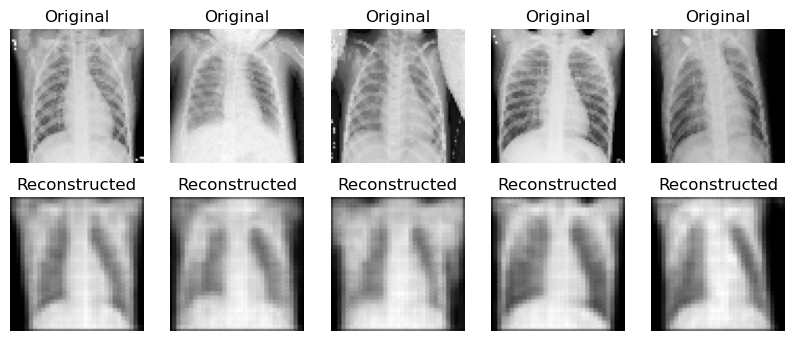

Error rate:0.29914529914529914
Precision:0.7959183673469388 Sensitivity:0.7 Specificity:0.7008547008547008 f1:0.7448840381991815



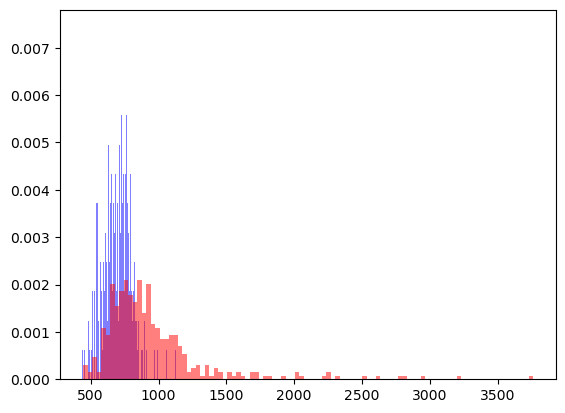

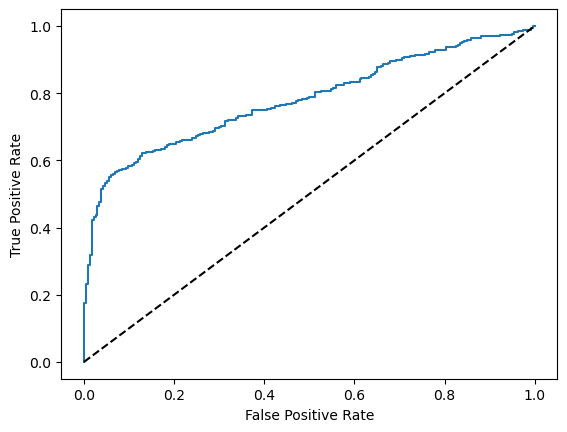

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import torch
from sklearn import metrics

def train_loop(model, loader):
    optim = torch.optim.Adam(model.parameters(), 5e-4, betas=(0.5, 0.999))
    for e in tqdm(range(EPOCHS)):
        model.train()
        loass_array = []
        for (x, _) in loader:
            x.requires_grad = False
            x.permute(0, 3, 1, 2)
            out = model(x)
            rec_err = (out - x) ** 2
            loss = rec_err.mean()
            loass_array.append(loss.item())
            optim.zero_grad()
            loss.backward()
            optim.step()
        loass_array = np.mean(loass_array)
        print('epochs:{}, loss:{}'.format(e, loass_array))
    torch.save(model.state_dict(), checkpoint_dir + '/winning architecture/AE_gray.pth')

if __name__ == '__main__':
    EPOCHS = 250
    model = AE(latent_size=64)
    train_loop(model, train_loader)


# Task 4 - Explainability - in train notebook